In [1]:
import numpy as np 
import pandas as pd 
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
prices_dataset =pd.read_csv('data/2330.csv', header=0)
prices_dataset.head()

,Date,Open,High,Low,Close,SMA5,SMA10,SMA20,SMA60,Vol,MA5,MA10,DIF,MACD9,OSC,K,D
0,2011/7/20,69.7,71.7,69.4,71.6,70.08,70.83,71.79,74.02,58272,59446,55917,-1.15,-1.00,-0.15,32.35%,26.05%
1,2011/7/21,71.4,71.6,70.6,71.6,70.26,70.83,71.66,74.05,33277,55219,54470,-1.04,-1.01,-0.03,46.77%,32.96%
2,2011/7/22,72.4,72.4,71.7,72.0,70.68,70.78,71.62,74.04,38244,45044,52998,-0.88,-0.98,0.10,60.35%,42.09%
3,2011/7/25,72.4,72.5,71.4,72.0,71.14,70.85,71.62,74.02,34963,44443,51283,-0.76,-0.94,0.18,69.40%,51.19%
4,2011/7/26,72.3,73.7,72.3,73.7,72.18,71.19,71.68,74.03,53159,43583,52599,-0.54,-0.86,0.32,79.60%,60.66%


In [4]:
wltw = prices_dataset
wltw.shape

(1661, 17)

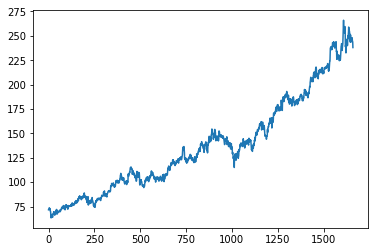

In [5]:
wltw_stock_prices = wltw.Close.values.astype('float32')

plt.plot(wltw_stock_prices)
plt.show()

wltw_stock_prices=wltw_stock_prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
wltw_stock_prices = scaler.fit_transform(wltw_stock_prices)

In [69]:
train_size = int(len(wltw_stock_prices) * 0.9)
test_size = len(wltw_stock_prices) - train_size
train, test = wltw_stock_prices[0:train_size,:], wltw_stock_prices[train_size:len(wltw_stock_prices),:]
print(len(train), len(test))

1494 167


In [70]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [71]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [72]:
trainX.shape

(1488, 5)

In [73]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [74]:
trainX.shape

(1488, 5, 1)

In [75]:
testX.shape

(161, 5, 1)

In [113]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    input_length=5,
    output_dim=100,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    50,
    return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(
    output_dim=16))
model.add(Dropout(0.2))
model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(5, 1), units=100)`
  import sys


compilation time :  0.01227712631225586


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=16)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 5, 100)            40800     
_________________________________________________________________
dropout_50 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_51 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_52 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
__________

In [115]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=100,
    validation_split=0.10)

/usr/local/lib/python3.6/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1339 samples, validate on 149 samples
Epoch 1/100
1339/1339 [==============================] - 2s 2ms/step - loss: 0.0247 - val_loss: 0.0088
Epoch 2/100
1339/1339 [==============================] - 0s 149us/step - loss: 0.0060 - val_loss: 0.0300
Epoch 3/100
1339/1339 [==============================] - 0s 150us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 4/100
1339/1339 [==============================] - 0s 142us/step - loss: 0.0042 - val_loss: 0.0028
Epoch 5/100
1339/1339 [==============================] - 0s 152us/step - loss: 0.0047 - val_loss: 2.4315e-04
Epoch 6/100
1339/1339 [==============================] - 0s 148us/step - loss: 0.0038 - val_loss: 2.4767e-04
Epoch 7/100
1339/1339 [==============================] - 0s 150us/step - loss: 0.0039 - val_loss: 0.0025
Epoch 8/100
1339/1339 [==============================] - 0s 133us/step - loss: 0.0039 - val_loss: 0.0104
Epoch 9/100
1339/1339 [==============================] - 0s 138us/step - loss: 0.0035 - val_loss: 0.0015
Ep

1339/1339 [==============================] - 0s 146us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 77/100
1339/1339 [==============================] - 0s 143us/step - loss: 0.0010 - val_loss: 4.2453e-04
Epoch 78/100
1339/1339 [==============================] - 0s 144us/step - loss: 0.0012 - val_loss: 7.1953e-04
Epoch 79/100
1339/1339 [==============================] - 0s 153us/step - loss: 0.0011 - val_loss: 0.0048
Epoch 80/100
1339/1339 [==============================] - 0s 146us/step - loss: 0.0011 - val_loss: 0.0039
Epoch 81/100
1339/1339 [==============================] - 0s 135us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 82/100
1339/1339 [==============================] - 0s 145us/step - loss: 0.0012 - val_loss: 0.0029
Epoch 83/100
1339/1339 [==============================] - 0s 151us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 84/100
1339/1339 [==============================] - 0s 151us/step - loss: 0.0011 - val_loss: 7.4696e-04
Epoch 85/100
1339/1339 [=======================

In [116]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #print ('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        #
        plt.plot(padding + data, label='Prediction')
        plt.plot(padding + data, 'b^')
    plt.legend()
    plt.show()
    
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 5 steps before shifting prediction run forward by 5 steps
    #Predict length is how many points I want to predict
    #window_size is how many time steps I need for the prediction
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [117]:
predictions = predict_sequences_multiple(model, testX, 5, 1)

In [118]:
len(predictions)

161

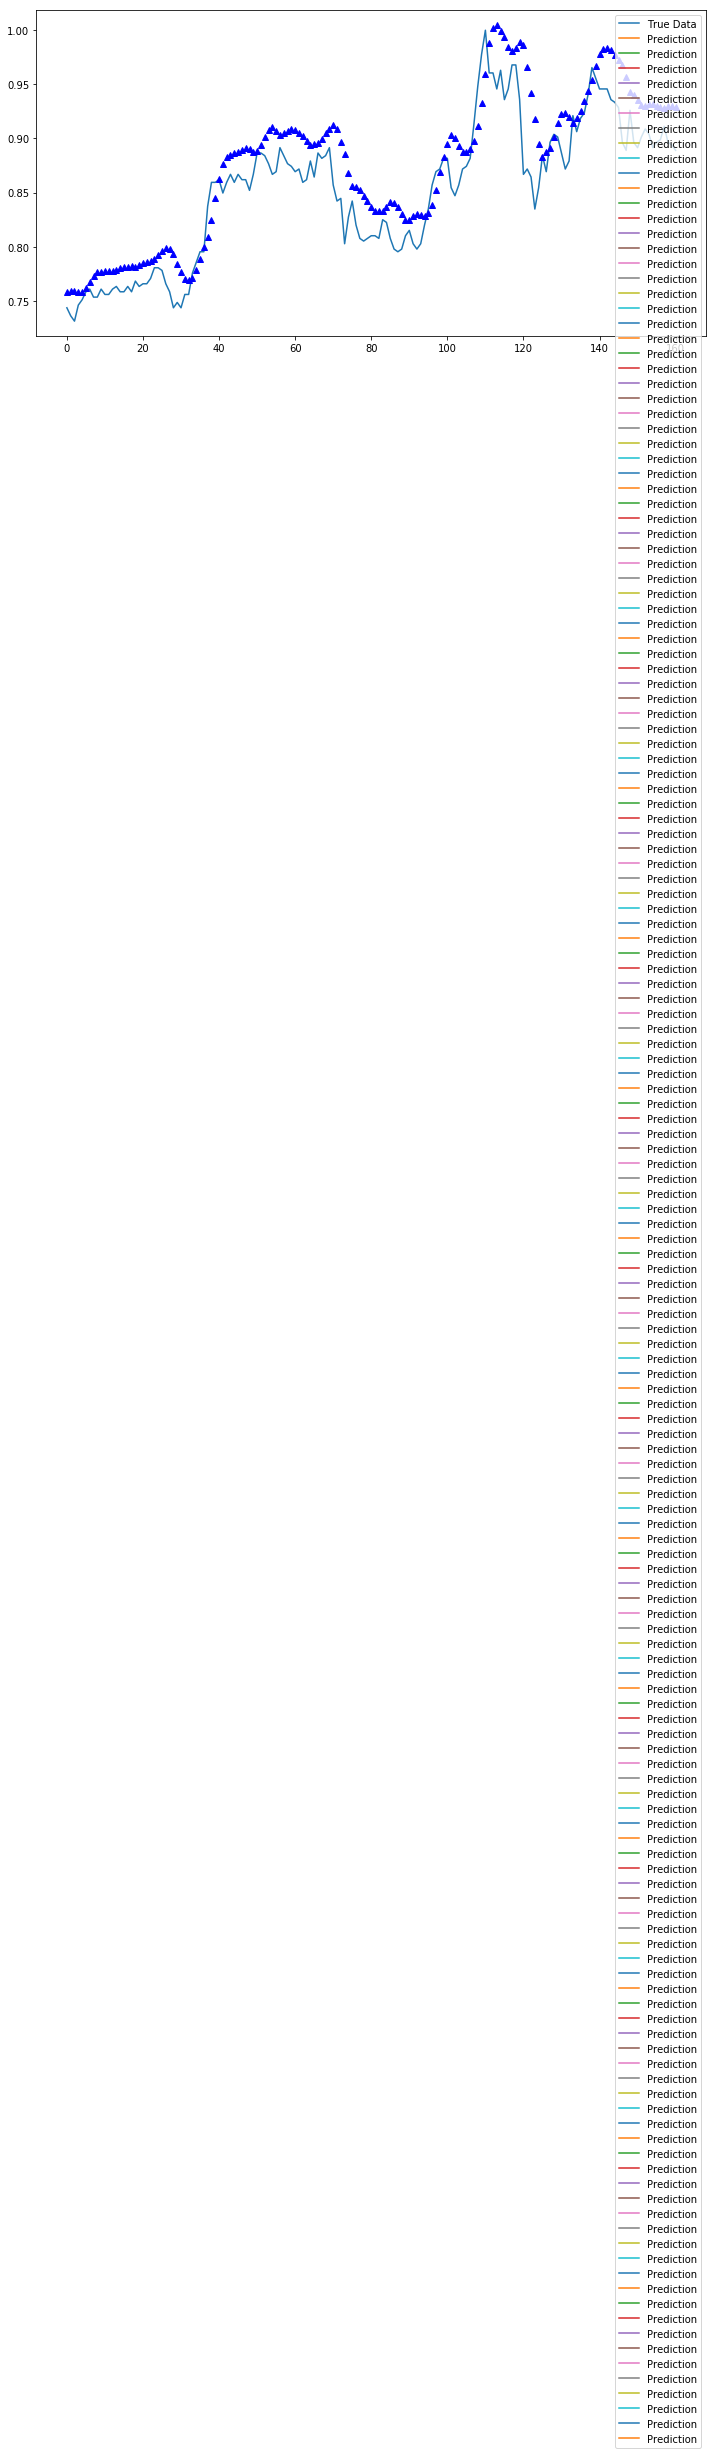

In [119]:
plot_results_multiple(predictions, testY, 1)

In [ ]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    input_length=5,
    output_dim=128,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    64,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Dropout(0.4))
# model.add(Dense(64))
# model.add(Dropout(0.4))
model.add(Dense(1,activation='linear'))
# model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)